# Imports & variable definitions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import os
from functools import reduce

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [2]:
country_set = ['South Africa', 'Nigeria', 'India', 'China', 'Japan', 
               'South Korea', 'Germany', 'Poland', 'France', 'United Kingdom', 
               'Finland', 'Brazil', 'Chile', 'Colombia', 'Saudi Arabia', 'Iran', 
               'Egypt', 'United States', 'Canada', 'Mexico']

start_year, end_year = 2015, 2021

# Happiness data input and preprocessing

In [3]:
# Read in data
happiness_data = {}

for f in os.listdir('../data/WHI/'):
    year = f.split('.')[0]
    happiness_data[year] = pd.read_csv('../data/WHI/' + f)

# Unify column names
happiness_data['2017'].rename(columns={'Happiness.Score': 'Happiness Score'}, inplace=True)

happiness_data['2018'].rename(columns={'Country or region':'Country',
                        'Score':'Happiness Score'}, inplace=True)
happiness_data['2019'].rename(columns={'Country or region':'Country',
                        'Score':'Happiness Score'}, inplace=True)

happiness_data['2020'].rename(columns={'Country name': 'Country',
                        'Ladder score':'Happiness Score'}, inplace=True)
happiness_data['2021'].rename(columns={'Country name': 'Country',
                        'Ladder score':'Happiness Score'}, inplace=True)

happiness_data['2022'].rename(columns={'Happiness score': 'Happiness Score'}, inplace=True)

# Change number format for 2022 data to match other data
happiness_data['2022']['Happiness Score'] = happiness_data['2022']['Happiness Score'].str.replace(',', '.').astype(float)

# Remove every column except Country, Region and Happiness Score and add a column for the year
for df in happiness_data:
    happiness_data[df] = happiness_data[df][['Country', 'Happiness Score']]
    happiness_data[df]['Year'] = df

# Merge all years in one frame
happiness_df = pd.concat(happiness_data, ignore_index=True)

# Rearrange columns
happiness_df = happiness_df[['Country', 'Year', 'Happiness Score']]

happiness_df

,Country,Year,Happiness Score
0,Switzerland,2015,7.587
1,Iceland,2015,7.561
2,Denmark,2015,7.527
3,Norway,2015,7.522
4,Canada,2015,7.427
...,...,...,...
1226,Benin,2016,3.484
1227,Afghanistan,2016,3.360
1228,Togo,2016,3.303
1229,Syria,2016,3.069


In [4]:
# Remove invalid countries
happiness_df.drop(happiness_df.loc[happiness_df['Country'] == 'xx'].index, inplace=True)

# Convert Year to int
happiness_df['Year'] = happiness_df['Year'].astype(int)

# Filter to only include the countries we want to predict
happiness_df = happiness_df.loc[happiness_df['Country'].isin(country_set)].copy()

# Filter to 2015-2021
happiness_df = happiness_df.loc[happiness_df['Year'].isin(range(start_year, end_year+1))]

# Sort by year
happiness_df.sort_values(by=['Year'], inplace=True)

happiness_df.head()

,Country,Year,Happiness Score
4,Canada,2015,7.427
116,India,2015,4.565
112,South Africa,2015,4.642
109,Iran,2015,4.686
83,China,2015,5.140


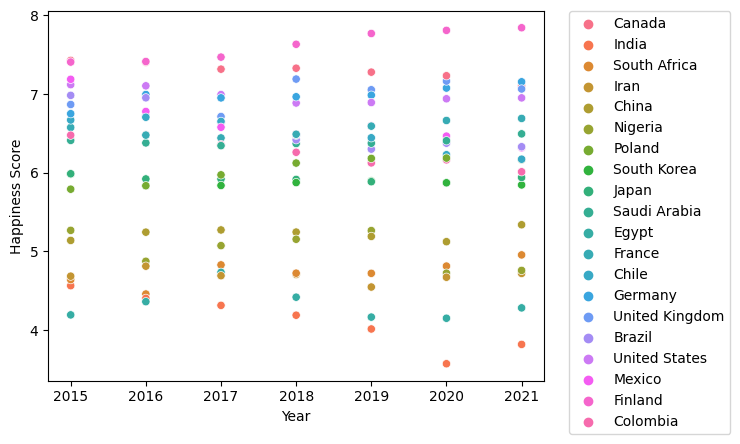

In [5]:
# Plot data for each country
hp_plt = sns.scatterplot(data=happiness_df, x='Year', y='Happiness Score', hue='Country')
hp_plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [6]:
#rng = np.random.RandomState(42) #Beispieldaten aus zwei Schwingungen
#x = 10 * rng.rand(200)

#def model(x, sigma=0.3):
#    fast_oscillation = np.sin(5 * x)
#    slow_oscillation = np.sin(0.5 * x)
#    noise = sigma * rng.randn(len(x))
#
#    return slow_oscillation + fast_oscillation + noise

#y = model(x)
#plt.errorbar(x, y, 0.3, fmt='o'); # Konfidenzintervall

## Enrich happiness data

### Human rights data

In [7]:
hr_df = pd.read_csv('../data/human_rights.csv')

# Filter to 2015-2021
hr_df = hr_df.loc[hr_df['Year'].isin(range(start_year, end_year+1))]

# Drop and rename columns
hr_df.drop(columns=['Code', 'region'], inplace=True)
hr_df.rename(columns={'Entity': 'Country', 'civ_libs_vdem_owid':'Human Rights Score'}, inplace=True)

# Filter to country set
hr_df = hr_df[hr_df['Country'].isin(country_set)]

#hr_df.loc[hr_df['Human Rights Score'].isna()]

contains = [hr_df['Country'].str.contains(i) for i in country_set]
resul = hr_df[np.all(contains, axis=0)]

resul

,Country,Year,Human Rights Score


### CO2 emissions per capita data

In [8]:
co2_df = pd.read_excel('../data/co2_emissions.xlsx', sheet_name='fossil_CO2_per_capita_by_countr')

# Drop unnecessary columns
co2_df.drop(columns=['EDGAR Country Code','Substance'], inplace=True)

# Melt frame
co2_df = pd.melt(co2_df, id_vars=['Country'], var_name='Year', value_name='CO2 Emissions per capita in tons')

# Filter to 2015-2021
co2_df = co2_df.loc[co2_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
co2_df = co2_df[co2_df['Country'].isin(country_set)]

co2_df.head()

,Country,Year,CO2 Emissions per capita in tons
9612,Brazil,2015,2.563284
9618,Canada,2015,16.318756
9620,Chile,2015,4.732708
9621,China,2015,7.710513
9627,Colombia,2015,1.683085


### Population growth in % data

In [9]:
pg_df = pd.read_csv('../data/population_growth.csv')

# Remove unnecessary columns
pg_df.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 67'], inplace=True)

# Rename country column to match other frames
pg_df.rename(columns={'Country Name': 'Country'}, inplace=True)

# Rename some countries to match other data
pg_df['Country'].replace({'Iran, Islamic Rep.': 'Iran',
                          'Korea, Rep.': 'South Korea',
                          'Egypt, Arab Rep.': 'Egypt'}, inplace=True)

# Melt frame
pg_df = pd.melt(pg_df, id_vars=['Country'], var_name='Year', value_name='Population Growth % per year')

# Convert Year to int
pg_df['Year'] = pg_df['Year'].astype(int)

# Filter to 2015-2021
pg_df = pg_df.loc[pg_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
pg_df = pg_df[pg_df['Country'].isin(country_set)]

pg_df.head()

,Country,Year,Population Growth % per year
14659,Brazil,2015,0.845993
14665,Canada,2015,0.746339
14669,Chile,2015,1.029426
14670,China,2015,0.581456
14675,Colombia,2015,0.941994


### Military expenditure % of GDP data

In [10]:
me_df = pd.read_csv('../data/military_expenditure.csv')

# Drop unnecessary columns
me_df.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 67'], inplace=True)

# Rename country column to match other frames
me_df.rename(columns={'Country Name': 'Country'}, inplace=True)

# Rename some countries to match other data
me_df['Country'].replace({'Iran, Islamic Rep.': 'Iran',
                          'Korea, Rep.': 'South Korea',
                          'Egypt, Arab Rep.': 'Egypt'}, inplace=True)

# Melt frame
me_df = pd.melt(me_df, id_vars=['Country'], var_name='Year', value_name='Military Expenditure % of GDP')

# Convert Year to int
me_df['Year'] = me_df['Year'].astype(int)

# Filter to 2015-2021
me_df = me_df.loc[me_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
me_df = me_df[me_df['Country'].isin(country_set)]

me_df.head()

,Country,Year,Military Expenditure % of GDP
14659,Brazil,2015,1.365517
14665,Canada,2015,1.152709
14669,Chile,2015,1.898487
14670,China,2015,1.750718
14675,Colombia,2015,3.109960


### Inflation of consumer prices data

In [11]:
if_df = pd.read_csv('../data/inflation_consumer_prices.csv')

# Drop unnecessary columns
if_df.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 67'], inplace=True)

# Rename country column to match other frames
if_df.rename(columns={'Country Name': 'Country'}, inplace=True)

# Rename some countries to match other data
if_df['Country'].replace({'Iran, Islamic Rep.': 'Iran',
                          'Korea, Rep.': 'South Korea',
                          'Egypt, Arab Rep.': 'Egypt'}, inplace=True)

# Melt frame
if_df = pd.melt(if_df, id_vars=['Country'], var_name='Year', value_name='Inflation % consumer prices')

# Convert Year to int
if_df['Year'] = if_df['Year'].astype(int)

# Filter to 2015-2021
if_df = if_df.loc[if_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
if_df = if_df[if_df['Country'].isin(country_set)]

if_df.head()

,Country,Year,Inflation % consumer prices
14659,Brazil,2015,9.029901
14665,Canada,2015,1.125241
14669,Chile,2015,4.348774
14670,China,2015,1.437024
14675,Colombia,2015,4.989831


### Power consumption per capita data

In [12]:
pc_df = pd.read_csv('../data/per-capita-energy-use.csv')

# Drop unnecessary columns
pc_df.drop(columns=['Code'], inplace=True)

# Rename country column to match other frames
pc_df.rename(columns={'Entity': 'Country'}, inplace=True)

# Filter to 2015-2021
pc_df = pc_df.loc[pc_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
pc_df = pc_df[pc_df['Country'].isin(country_set)]

pc_df.head()

,Country,Year,Primary energy consumption per capita (kWh/person)
1224,Brazil,2015,16782.990
1225,Brazil,2016,16277.570
1226,Brazil,2017,16325.418
1227,Brazil,2018,16260.365
1228,Brazil,2019,16467.885


### Rural population % of total population data

In [13]:
rp_df = pd.read_csv('../data/rural_population.csv')

# Drop unnecessary columns
rp_df.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 67'], inplace=True)

# Rename country column to match other frames
rp_df.rename(columns={'Country Name': 'Country'}, inplace=True)

# Rename some countries to match other data
rp_df['Country'].replace({'Iran, Islamic Rep.': 'Iran',
                          'Korea, Rep.': 'South Korea',
                          'Egypt, Arab Rep.': 'Egypt'}, inplace=True)

# Melt frame
rp_df = pd.melt(rp_df, id_vars=['Country'], var_name='Year', value_name='Rural Population % of total population')

# Convert Year to int
rp_df['Year'] = rp_df['Year'].astype(int)

# Filter to 2015-2021
rp_df = rp_df.loc[rp_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
rp_df = rp_df[rp_df['Country'].isin(country_set)]

rp_df.loc[rp_df['Rural Population % of total population'].isna()]

,Country,Year,Rural Population % of total population


### Life expectancy at birth data

In [14]:
le_df = pd.read_csv('../data/life-expectancy.csv')

# Drop unnecessary columns
le_df.drop(columns=['Code'], inplace=True)

# Rename country column to match other frames
le_df.rename(columns={'Entity': 'Country'}, inplace=True)

# Filter to 2015-2021
le_df = le_df.loc[le_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
le_df = le_df[le_df['Country'].isin(country_set)]

le_df.loc[le_df['Life expectancy at birth (historical)'].isna()]

,Country,Year,Life expectancy at birth (historical)


### GDP per capita data

In [15]:
gdp_df = pd.read_csv('../data/gdp-per-capita.csv')

# Drop unnecessary columns
gdp_df.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 67'], inplace=True)

# Rename country column to match other frames
gdp_df.rename(columns={'Country Name': 'Country'}, inplace=True)

# Rename some countries to match other data
gdp_df['Country'].replace({'Iran, Islamic Rep.': 'Iran',
                          'Korea, Rep.': 'South Korea',
                          'Egypt, Arab Rep.': 'Egypt'}, inplace=True)

# Melt frame
gdp_df = pd.melt(gdp_df, id_vars=['Country'], var_name='Year', value_name='GDP per capita (current US$)')

# Convert Year to int
gdp_df['Year'] = gdp_df['Year'].astype(int)

# Filter to 2015-2021
gdp_df = gdp_df.loc[gdp_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
gdp_df = gdp_df[gdp_df['Country'].isin(country_set)]

gdp_df.loc[gdp_df['GDP per capita (current US$)'].isna()]

,Country,Year,GDP per capita (current US$)


### World giving index data

In [16]:
wg_df = pd.read_csv('../data/world-giving-index.csv')

# Melt frame
wg_df = pd.melt(wg_df, id_vars=['Country'], var_name='Year', value_name='World Giving Index (% of people donating to charity')

# Convert Year to int
wg_df['Year'] = wg_df['Year'].astype(int)

# Filter to 2015-2021
wg_df = wg_df.loc[wg_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
wg_df = wg_df[wg_df['Country'].isin(country_set)]

wg_df.loc[wg_df['World Giving Index (% of people donating to charity'].isna()]

,Country,Year,World Giving Index (% of people donating to charity


### Corruption perception index data

In [17]:
cpi_df = pd.read_csv('../data/corruption-perception-index.csv', sep=';')

# Rename USA and South Korea to match other dataframes
cpi_df.loc[cpi_df['country'] == 'KOR', 'Country name'] = 'South Korea'
cpi_df.loc[cpi_df['country'] == 'USA', 'Country name'] = 'United States' 

# Drop unnecessary columns
cpi_df.drop(columns=['Indicator name','indicator','country','note'], inplace=True)

# Rename columns to match other frames
cpi_df.rename(columns={'Country name': 'Country', 'time': 'Year', 'value': 'Corruption Perception Index'}, inplace=True)

# Filter to 2015-2021
cpi_df = cpi_df.loc[cpi_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
cpi_df = cpi_df[cpi_df['Country'].isin(country_set)]

cpi_df.loc[cpi_df['Corruption Perception Index'].isna()]

,Country,Year,Corruption Perception Index


### Social support data

In [18]:
ss_df = pd.read_csv('../data/social-support.csv', sep=';', decimal=',')

# Filter to Total
ss_df = ss_df[ss_df['SUBJECT'] == 'TOT']

# Drop unnecessary columns
ss_df.drop(columns=['INDICATOR','SUBJECT','MEASURE'], inplace=True)

# Rename columns to match other frames
ss_df.rename(columns={'LOCATION':'Country',
                      'TIME': 'Year',
                      'Value': 'Social Support Score'}, inplace=True)

# Filter to 2015-2021
ss_df = ss_df.loc[ss_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
ss_df = ss_df[ss_df['Country'].isin(country_set)]

ss_df.head()

,Country,Year,Social Support Score
3295,Canada,2015,93.867164
3296,Canada,2016,92.336711
3297,Canada,2017,92.953595
3298,Canada,2018,91.733480
3299,Canada,2019,92.494607


## Merge happiness data with all other data

In [19]:
df_to_merge = [happiness_df, hr_df, co2_df, pg_df, me_df, if_df, pc_df, rp_df, le_df, gdp_df, wg_df, cpi_df, ss_df]

hp_ml_df = reduce(lambda left,right: pd.merge(left,right,on=['Country', 'Year'], how='outer'), df_to_merge)

hp_ml_df.to_excel('../master_data_table.xlsx', index=False)

hp_ml_df

,Country,Year,Happiness Score,Human Rights Score,CO2 Emissions per capita in tons,Population Growth % per year,Military Expenditure % of GDP,Inflation % consumer prices,Primary energy consumption per capita (kWh/person),Rural Population % of total population,Life expectancy at birth (historical),GDP per capita (current US$),World Giving Index (% of people donating to charity,Corruption Perception Index,Social Support Score
0,Canada,2015,7.427,0.947,16.318756,0.746339,1.152709,1.125241,113089.450,18.741,81.9,43596.135537,67.0,83,93.867164
1,India,2015,4.565,0.672,1.725289,1.187795,2.457451,4.906973,6070.304,67.223,69.6,1590.173918,20.0,38,NaN
2,South Africa,2015,4.642,0.863,8.298320,2.074017,1.099182,4.540642,25328.998,35.172,63.9,6204.929901,19.0,44,89.525664
3,Iran,2015,4.686,0.299,7.930465,2.261785,2.760312,12.484682,33744.590,26.642,75.1,4990.936798,54.0,27,NaN
4,China,2015,5.140,0.269,7.710513,0.581456,1.750718,1.437024,25315.799,44.500,77.0,8016.431435,8.0,37,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Saudi Arabia,2021,6.494,0.144,16.629278,-0.129847,6.594476,3.063290,83635.400,15.492,76.9,23185.870792,28.0,53,NaN
136,United States,2021,6.951,0.923,14.237032,0.118380,3.483216,4.697859,76633.950,17.127,77.2,70248.629000,45.0,67,91.959084
137,United Kingdom,2021,7.064,0.886,4.953739,0.365410,2.223228,2.518371,29641.014,15.848,80.7,46510.282782,59.0,78,85.370359
138,Colombia,2021,6.012,0.639,1.533738,1.143821,3.401894,3.495058,10371.598,18.260,72.8,6104.136709,22.0,39,78.873106


# Data analysis with Random Forest Regressor and SVR

In [20]:
cols = ['Country', 'Year', 'Actual', 'Prediction RFR', 'Prediction SVR', 'R2 Score RF', 'R2 Score SVR', 'RMSE RF', 'RMSE SVR']
lst = []

for c in hp_ml_df['Country'].unique():

    # Filter to country
    c_df = hp_ml_df.loc[hp_ml_df['Country'] == c].copy()

    # Remove Social Support if NaN
    if c_df['Social Support Score'].isna().any():
        c_df.drop(columns=['Social Support Score'], inplace=True)

    # Remove country column
    c_df.drop(columns=['Country'], inplace=True)

    # Define X and y
    X = c_df.drop(columns=['Happiness Score']) # Features
    y = c_df['Happiness Score'] # Target variable

    # Split into train and test sets
    X_rows = len(X.index)
    y_rows = len(y.index)

    X_train = X.iloc[:X_rows-2]
    X_test = X.iloc[X_rows-2:]
    y_train = y.iloc[:y_rows-2]
    y_test = y.iloc[y_rows-2:]

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Make prediction - Random Forest
    forest = RandomForestRegressor(n_estimators=100) # 100 Decision Trees
    forest.fit(X_train, y_train)

    y_pred_rf = forest.predict(X_test)

    # Make prediction - SVR
    svr = SVR()
    svr.fit(X_train, y_train)

    y_pred_svr = svr.predict(X_test)

    # Calculate R2 Score
    r2_rf = r2_score(y_test, y_pred_rf)
    r2_svr = r2_score(y_test, y_pred_svr)

    # Calculate Root Mean Squared Error
    rmse_rf = float(format(np.sqrt(mean_squared_error(y_test, y_pred_rf)), '.3f'))
    rmse_svr = float(format(np.sqrt(mean_squared_error(y_test, y_pred_svr)), '.3f'))
    
    
    lst.append([[c,c], X_test['Year'].tolist(), y_test, y_pred_rf, y_pred_svr, [r2_rf, r2_rf], [r2_svr, r2_svr], [rmse_rf, rmse_rf], [rmse_svr, rmse_svr]])



output_f = pd.DataFrame(lst, columns=cols)
output_f = output_f.explode(output_f.columns.tolist())

output_f.to_excel('../happiness-predictions_new.xlsx', index=False)

# Define output_f from already calculated file
output_f = pd.read_excel('../happiness-predictions.xlsx')

output_f.head()

,Country,Year,Actual,Prediction RFR,Prediction SVR,R2 Score RF,R2 Score SVR,RMSE RF,RMSE SVR
0,Canada,2020,7.2321,7.34508,7.352500,-6.298036,-8.209488,0.174,0.196
1,Canada,2021,7.1030,7.32221,7.352500,-6.298036,-8.209488,0.174,0.196
2,India,2020,3.5733,4.24689,4.299700,-18.745748,-23.200562,0.546,0.604
3,India,2021,3.8190,4.19621,4.269354,-18.745748,-23.200562,0.546,0.604
4,South Africa,2020,4.8141,4.69750,4.674034,-6.239182,-8.606932,0.191,0.220


## Plot the data

### Region deviation plot

In [21]:
# Group countries by region and calculate deviation from prediction
plot_region_frame = output_f.drop(columns=['R2 Score RF', 'R2 Score SVR', 'RMSE RF', 'RMSE SVR'])
plot_region_frame_r2_mse = output_f.copy()

plot_region_frame['RFR Pred-Act'] = plot_region_frame['Prediction RFR'] - plot_region_frame['Actual']
plot_region_frame['SVR Pred-Act'] = plot_region_frame['Prediction SVR'] - plot_region_frame['Actual']

country_region_dict = pd.read_csv('../data/country_region_mapping.csv', sep=';')

plot_region_frame = pd.merge(plot_region_frame, country_region_dict, on='Country', how='left')
plot_region_frame_r2_mse = pd.merge(plot_region_frame_r2_mse, country_region_dict, on='Country', how='left')
plot_region_frame = plot_region_frame.groupby(['Geographical Region', 'Year']).mean()
plot_region_frame_r2_mse = plot_region_frame_r2_mse.groupby(['Geographical Region', 'Year']).mean()

plot_region_frame

melted_pl_r_f = pd.melt(plot_region_frame.reset_index(), id_vars=['Geographical Region', 'Year'], value_vars=['RFR Pred-Act', 'SVR Pred-Act'], var_name='Type', value_name='Prediction-Actual')
melted_pl_r_r2_mse = pd.melt(plot_region_frame_r2_mse.reset_index(), id_vars=['Geographical Region', 'Year'], value_vars=['R2 Score RF', 'R2 Score SVR', 'RMSE RF', 'RMSE SVR'], var_name='Metric', value_name='Value')

melted_pl_r_f.head()

/tmp/ipykernel_1020/762951713.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plot_region_frame = plot_region_frame.groupby(['Geographical Region', 'Year']).mean()
/tmp/ipykernel_1020/762951713.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plot_region_frame_r2_mse = plot_region_frame_r2_mse.groupby(['Geographical Region', 'Year']).mean()


,Geographical Region,Year,Type,Prediction-Actual
0,Africa,2020,RFR Pred-Act,0.150925
1,Africa,2021,RFR Pred-Act,0.075340
2,Asia,2020,RFR Pred-Act,0.205013
3,Asia,2021,RFR Pred-Act,0.063977
4,Europe,2020,RFR Pred-Act,-0.157530


Text(0.5, 1.0, 'Deviation from Prediction by Region 2020')

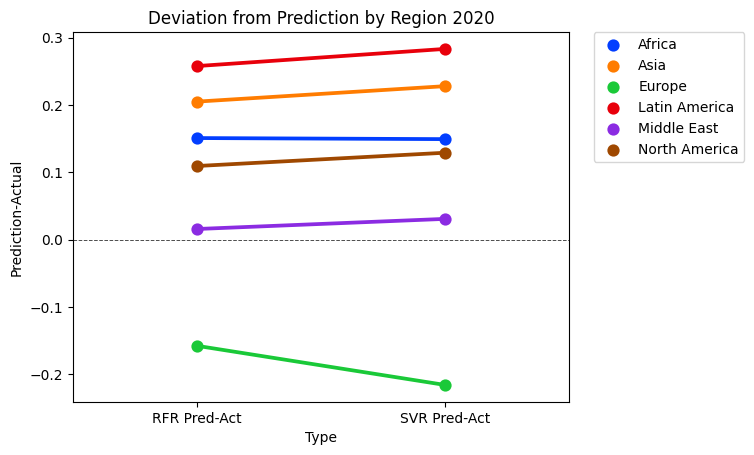

In [22]:
# Plot deviation from prediction by region
melted_pl_r_f_20 = melted_pl_r_f.loc[melted_pl_r_f['Year'] == 2020]
plt = sns.pointplot(data=melted_pl_r_f_20, x='Type', y='Prediction-Actual', hue='Geographical Region', errorbar=("pi", 100), join=True, palette='bright')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(0, linestyle='--', color='black', linewidth=0.7, alpha=0.7)
plt.set_title('Deviation from Prediction by Region 2020')

Text(0.5, 1.0, 'Deviation from Prediction by Region 2021')

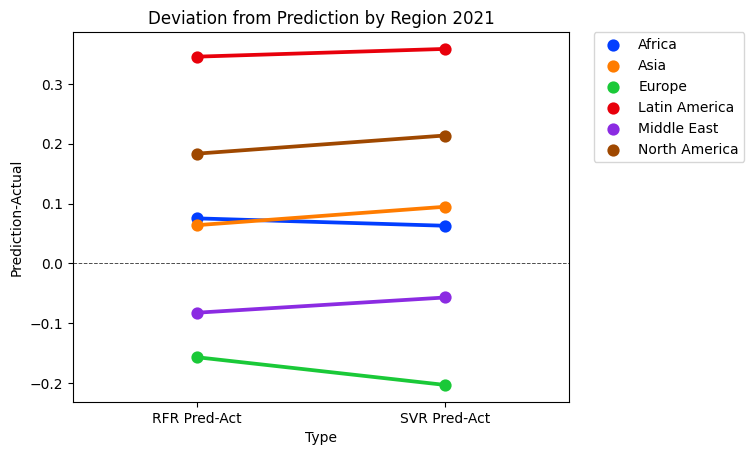

In [23]:
melted_pl_r_f_21 = melted_pl_r_f.loc[melted_pl_r_f['Year'] == 2021]
plt = sns.pointplot(data=melted_pl_r_f_21, x='Type', y='Prediction-Actual', hue='Geographical Region', errorbar=("pi", 100), join=True, palette='bright')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(0, linestyle='--', color='black', linewidth=0.7, alpha=0.7)
plt.set_title('Deviation from Prediction by Region 2021')

Text(0.5, 1.0, 'Mean Deviation from Prediction by Region 2020-2021')

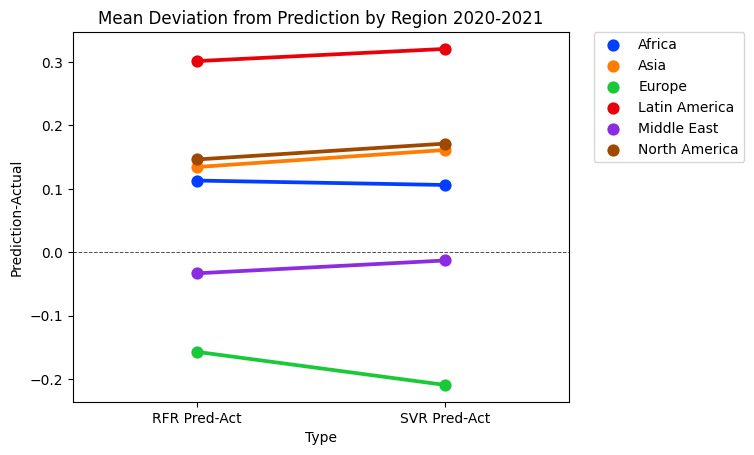

In [24]:
# Average Deviation from Prediction by Region
melted_pl_r_f_mean = melted_pl_r_f.drop(columns=['Year'])
melted_pl_r_f_mean = melted_pl_r_f_mean.groupby(['Geographical Region', 'Type']).mean()
#melted_pl_r_f_mean = melted_pl_r_f_mean.abs()
melted_pl_r_f_mean = melted_pl_r_f_mean.reset_index()

plt = sns.pointplot(data=melted_pl_r_f_mean, x='Type', y='Prediction-Actual', hue='Geographical Region', errorbar=("pi", 100), join=True, palette='bright')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(0, linestyle='--', color='black', linewidth=0.7, alpha=0.7)
plt.set_title('Mean Deviation from Prediction by Region 2020-2021')

Text(0.5, 1.0, 'Mean RMSE by Region 2020-2021')

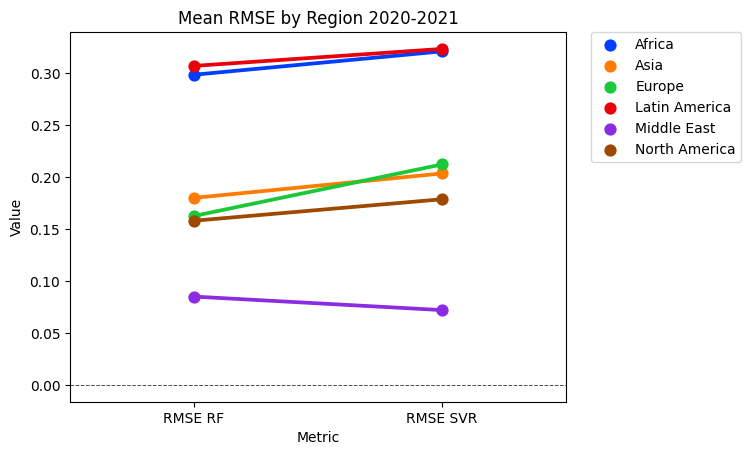

In [25]:
# Absolute Mean Squared Error by Region
#melted_pl_r_r2_mse_2020 = melted_pl_r_r2_mse.loc[melted_pl_r_r2_mse['Year'] == 2020]
melted_pl_r_r2_mse_2020 = melted_pl_r_r2_mse.drop(columns=['Year'])
melted_pl_r_r2_mse_2020 = melted_pl_r_r2_mse_2020.loc[melted_pl_r_r2_mse_2020['Metric'].isin(['RMSE RF', 'RMSE SVR'])]
melted_pl_r_r2_mse_2020 = melted_pl_r_r2_mse_2020.groupby(['Geographical Region', 'Metric']).mean()
melted_pl_r_r2_mse_2020 = melted_pl_r_r2_mse_2020.reset_index()

plt = sns.pointplot(data=melted_pl_r_r2_mse_2020, x='Metric', y='Value', hue='Geographical Region', errorbar=("pi", 100), join=True, palette='bright')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(0, linestyle='--', color='black', linewidth=0.7, alpha=0.7)
plt.set_title('Mean RMSE by Region 2020-2021')

### 2020 plot

Text(0.5, 1.0, 'Happiness Score 2020 - Actual vs Predictions')

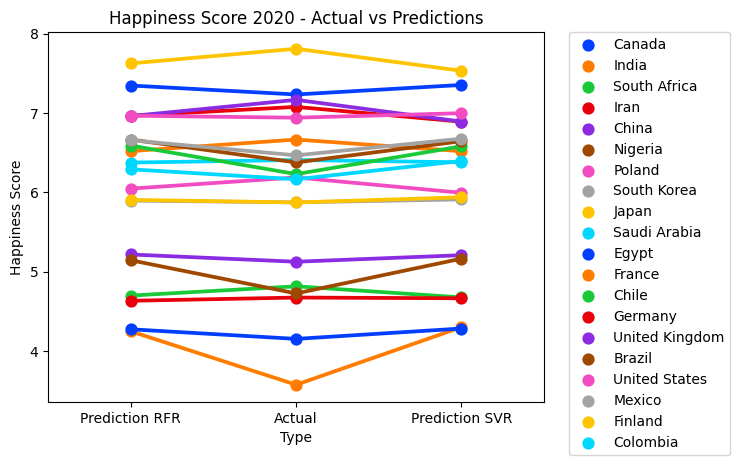

In [26]:
plot_frame = pd.melt(output_f, id_vars=['Country', 'Year'], value_vars=['Actual', 'Prediction RFR', 'Prediction SVR'], var_name='Type', value_name='Happiness Score')
plot_frame_20 = plot_frame.loc[plot_frame['Year'] == 2020].copy()

plt = sns.pointplot(data=plot_frame_20, x='Type', y='Happiness Score', order=['Prediction RFR','Actual','Prediction SVR'], hue='Country', errorbar=("pi", 100), join=True, palette='bright')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.set_title('Happiness Score 2020 - Actual vs Predictions')


### 2021 plot

Text(0.5, 1.0, 'Happiness Score 2021 - Actual vs Predictions')

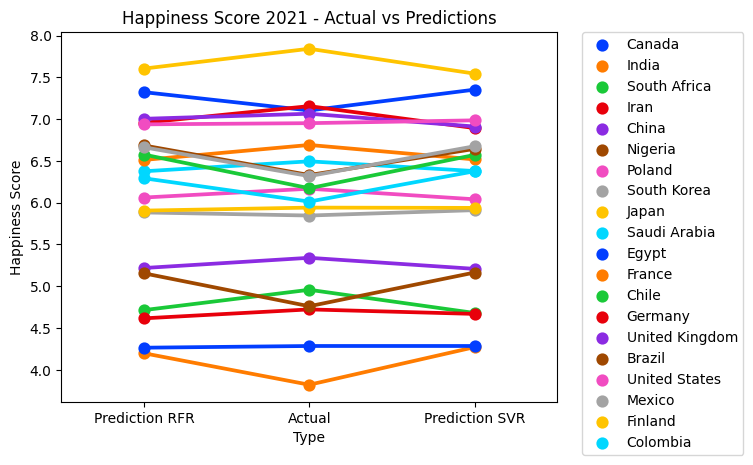

In [27]:
plot_frame_21 = plot_frame.loc[plot_frame['Year'] == 2021].copy()

plt = sns.pointplot(data=plot_frame_21, x='Type', y='Happiness Score', order=['Prediction RFR','Actual','Prediction SVR'], hue='Country', errorbar=("pi", 100), join=True, palette='bright')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.set_title('Happiness Score 2021 - Actual vs Predictions')

### Additional plots for presentation

In [40]:
plot_frame_line = plot_frame.loc[plot_frame['Country'].isin(["Finland"])].copy()
plot_frame_line = plot_frame_line.pivot_table(index='Year', columns='Type', values='Happiness Score', aggfunc='mean')
#plot_frame_line

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


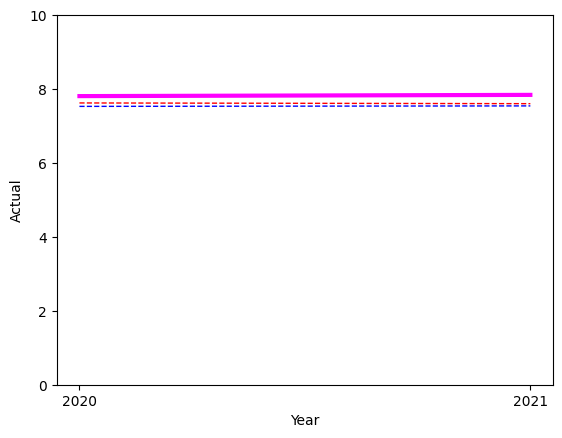

In [73]:
#plt = sns.lineplot(data=plot_frame_line, x='Year', y='Actual', palette='bright', hue='Country')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.set_title('Happiness Score 2020-2021 - Actual vs Predictions')

plt = sns.lineplot(x = 'Year', y = 'Actual', data=plot_frame_line, color='magenta', lw=3)
plt = sns.lineplot(x = 'Year', y = 'Prediction RFR', data=plot_frame_line, color='r', lw=1, ls='--')
plt = sns.lineplot(x = 'Year', y = 'Prediction SVR', data=plot_frame_line, color='b', lw=1, ls='--')
plt.set_yticks([0, 2, 4, 6, 8, 10])
plt.set_xticks([2020, 2021])
#xticks = plt.xaxis.get_major_ticks()
#for i in range(2, len(xticks)-2):
#    xticks[i].label1.set_visible(False)
#plt.set_yticklabels(['0', '2', '4', '6', '8', '10'])
#plt.legend(labels=['Actual','Prediction RFR','Prediction SVR'])
#plt.legend(labels=['x_1','y_1'], facecolor='white')